In [1]:
#!pip -q install einops
import numpy as np
import torch
from torch.utils.data import DataLoader
from set_data import load_real_weather, WeatherPairs, split_windows_train_val_test
from visualization import (plot_complete_data, 
                           plot_weatherpair_panel,
                           visualize_loss, plot_ctx_and_scenarios_panel)
from utils import *
from diffusion_model import DiffusionSchedule, TinyCondUNet1D
from diffusion_model_train import train_one_epoch, eval_epoch, EarlyStopping
from diffusion_model_generate import p_sample_loop
import error_metrics as em
np.set_printoptions(suppress=True)

VARS = 6
EPOCHS = 100
feature_names = ["T2M_MIN", "T2M_MAX", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN", "RH2M", "WS2M"]

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)



device: cpu


In [2]:

X, columns = load_real_weather("../../data/data_20150630_to_20250630.csv", 
                      start_date="2015-06-30", end_date="2024-06-30")
print("Real data shape:", X.shape)  # (days, number of features)

Real data shape: (3289, 6)


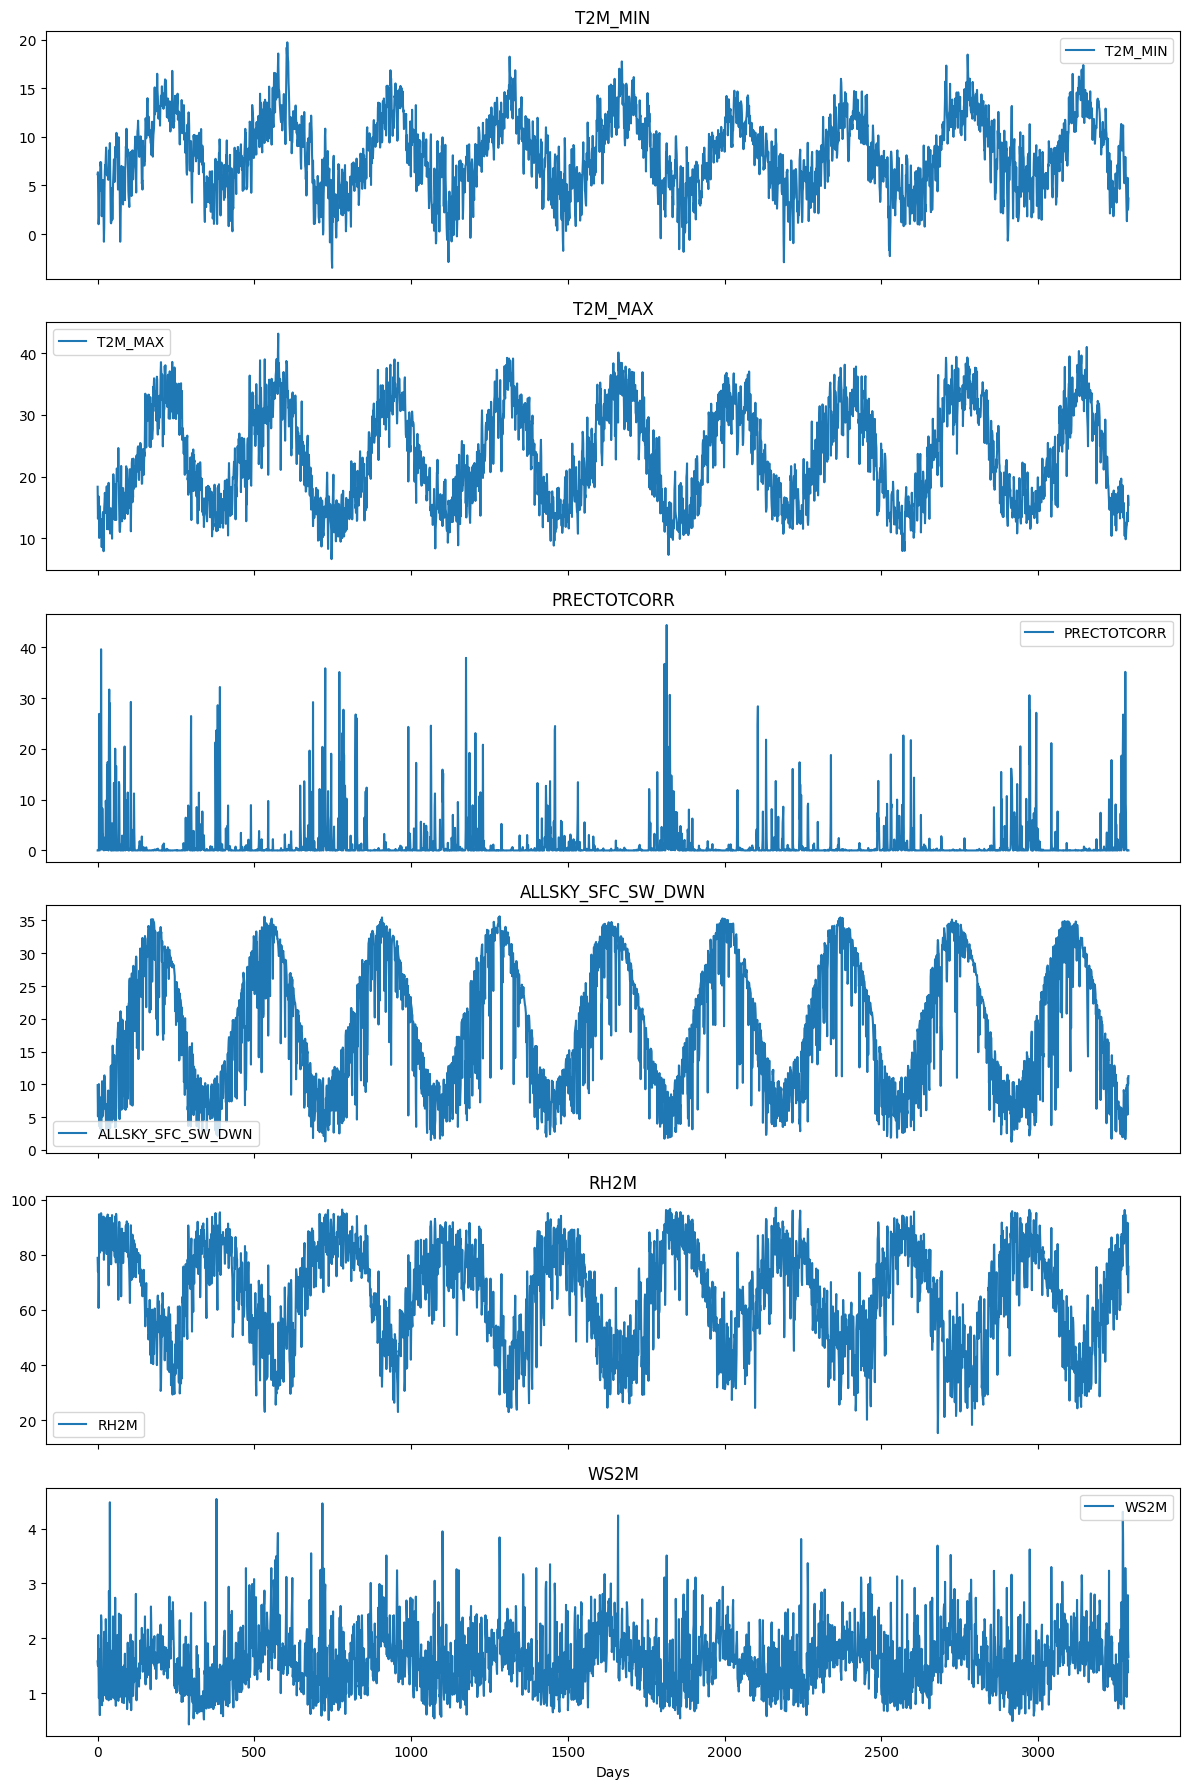

In [3]:
plot_complete_data(X, columns)

In [4]:
CTX = 60
HORIZON = 60
dataset = WeatherPairs(X, ctx=CTX, horizon=HORIZON, stride=1)
train_ds, val_ds, test_ds = split_windows_train_val_test(dataset, test_frac=0.1, val_frac=0.1, train_frac=0.8)



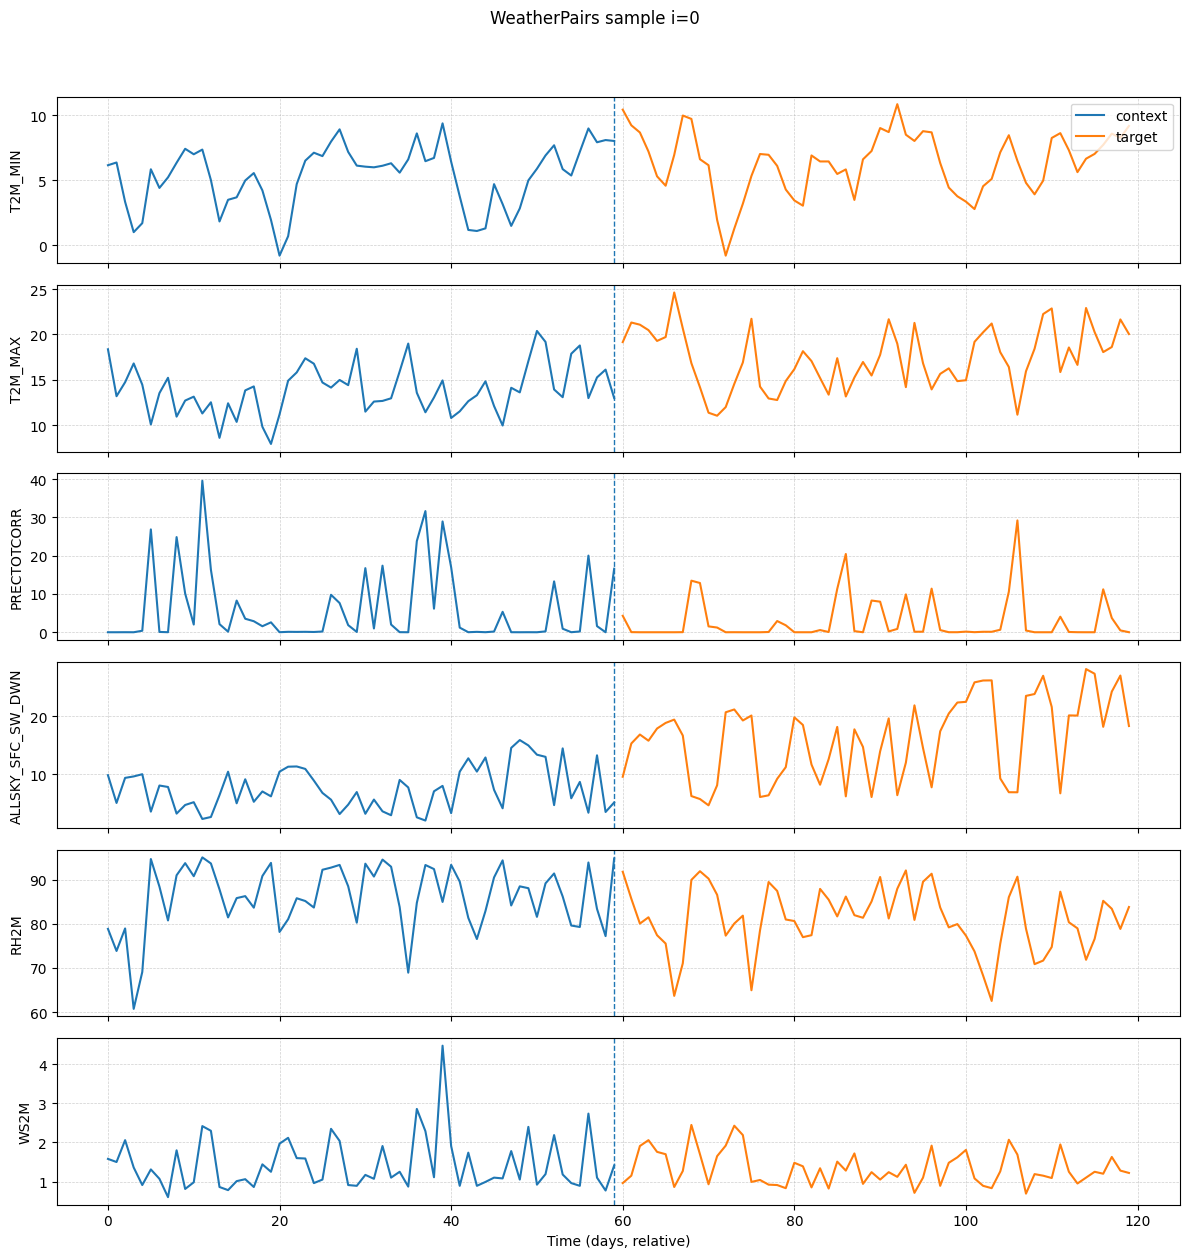

In [5]:
plot_weatherpair_panel(train_ds, i=0, feature_names=feature_names)

In [6]:
print("windows:", len(dataset))
print("train/val/test:", len(train_ds), len(val_ds), len(test_ds))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, drop_last=False)


windows: 3170
train/val/test: 2296 317 317


In [7]:
mean, std = fit_standardizer(train_ds)
mean_t = torch.tensor(mean, device=device)
std_t = torch.tensor(std, device=device)
print("mean:", mean, "\nstd:", std)

mean: [ 8.279258  23.20681    1.2304815 18.979977  65.8404     1.5848776] 
std: [ 3.7783682   7.657927    4.024448    9.812458   17.534721    0.55773836]


In [8]:
sched = DiffusionSchedule(T=250)

In [9]:
model = TinyCondUNet1D(in_vars=VARS, ctx_vars=VARS).to(device)


epoch 01 | train 0.6896 | val 0.4399 | best inf (bad 0/20)
epoch 02 | train 0.4066 | val 0.3787 | best 0.4399 (bad 0/20)
epoch 03 | train 0.3791 | val 0.3692 | best 0.3787 (bad 0/20)
epoch 04 | train 0.3710 | val 0.3281 | best 0.3692 (bad 0/20)
epoch 05 | train 0.3541 | val 0.3447 | best 0.3281 (bad 0/20)
epoch 06 | train 0.3565 | val 0.3392 | best 0.3281 (bad 1/20)
epoch 07 | train 0.3488 | val 0.3370 | best 0.3281 (bad 2/20)
epoch 08 | train 0.3323 | val 0.3323 | best 0.3281 (bad 3/20)
epoch 09 | train 0.3329 | val 0.3443 | best 0.3281 (bad 4/20)
epoch 10 | train 0.3324 | val 0.3363 | best 0.3281 (bad 5/20)
epoch 11 | train 0.3315 | val 0.3399 | best 0.3281 (bad 6/20)
epoch 12 | train 0.3274 | val 0.3290 | best 0.3281 (bad 7/20)
epoch 13 | train 0.3287 | val 0.3228 | best 0.3281 (bad 8/20)
epoch 14 | train 0.3270 | val 0.3104 | best 0.3228 (bad 0/20)
epoch 15 | train 0.3030 | val 0.3174 | best 0.3104 (bad 0/20)
epoch 16 | train 0.3123 | val 0.2915 | best 0.3104 (bad 1/20)
epoch 17 | 

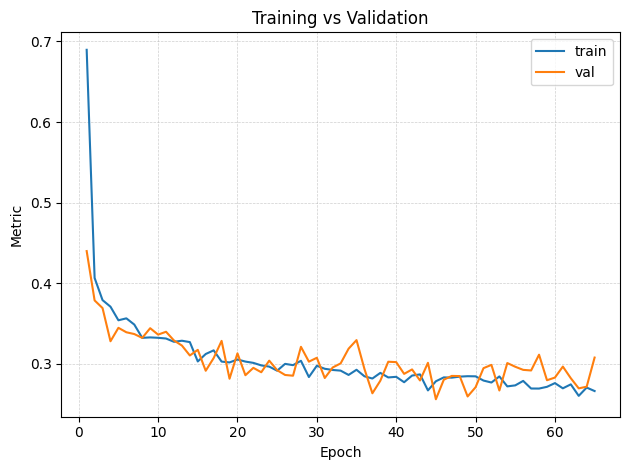

In [10]:
#opt = torch.optim.RMSprop(model.parameters(), lr=2e-4)
opt = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
    momentum=0.9,
    weight_decay=1e-4,
    nesterov=True
)

train_hist, val_hist = [], []

early = EarlyStopping(patience=20, min_delta=1e-4, mode="min")

for e in range(1, EPOCHS + 1):
    tr = train_one_epoch(opt, model, sched, device, train_loader, mean_t, std_t)
    va = eval_epoch(model, device, val_loader, sched, mean_t, std_t)

    train_hist.append(float(tr))
    val_hist.append(float(va))

    print(f"epoch {e:02d} | train {tr:.4f} | val {va:.4f} | best {early.best:.4f} (bad {early.num_bad}/{early.patience})")

    if early.step(va, model, e):
        print(f"Early stopping at epoch {e:02d}. Best val={early.best:.4f} at epoch {early.best_epoch:02d}.")
        break

# restore best weights before final eval / saving
early.restore_best(model)

visualize_loss(len(train_hist), train_hist, val_hist)



In [11]:
ctx_raw, tgt_raw = val_ds[0]
ctx_raw = ctx_raw.unsqueeze(0)  # (1,60,6)
tgt_raw = tgt_raw.numpy()       # (60,6)

scens = p_sample_loop(ctx_raw, model, device, sched, HORIZON, VARS, 
                      mean_t, std_t, n_scenarios=50).numpy() 
days = np.arange(HORIZON)


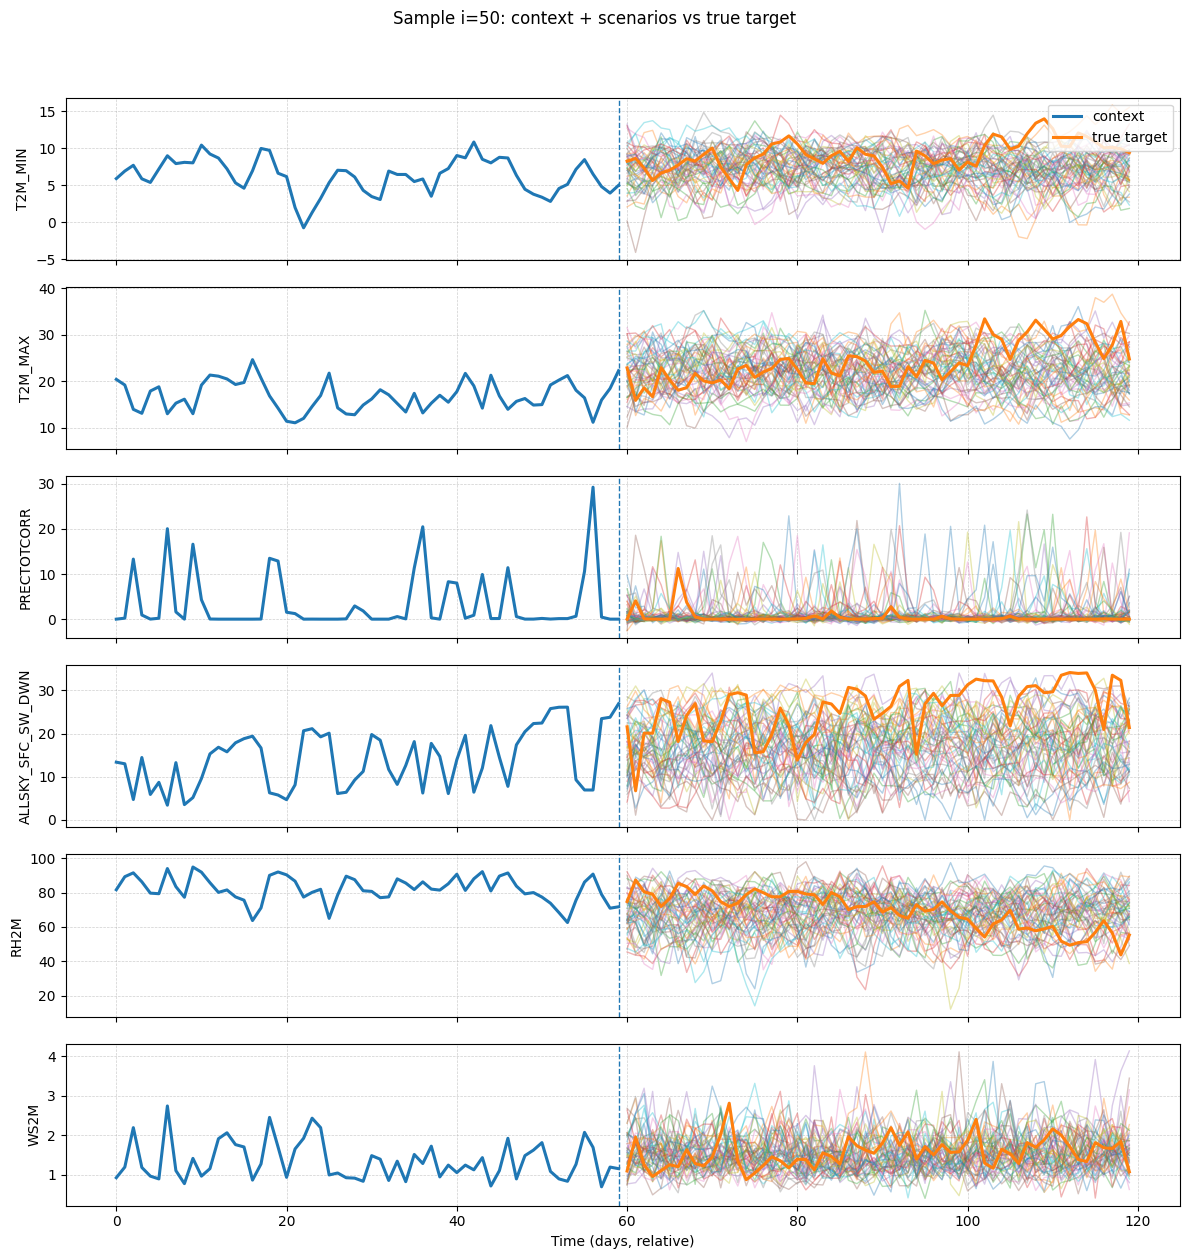

In [12]:
# Get one validation sample
ctx_raw, tgt_raw = val_ds[0]
ctx_raw = ctx_raw.unsqueeze(0)  # (1,CTX,VARS)

# Generate scenarios: (n_scenarios, HORIZON, VARS)
scens = p_sample_loop(ctx_raw, model, device, sched, HORIZON, VARS,
                      mean_t, std_t, n_scenarios=50).detach().cpu().numpy()

plot_ctx_and_scenarios_panel(
    dataset,
    50,
    scens,
    feature_names=feature_names,
    max_scen_to_plot=100
)


In [13]:
np.save("scenarios.npy", scens)

In [14]:
Omega = np.load("scenarios.npy")
Omega

array([[[ 3.5318837 , 22.35028   , -0.98563707, 22.108364  ,
         58.67418   ,  1.6158731 ],
        [ 5.681706  , 22.147747  , -0.33699656, 18.181986  ,
         65.02569   ,  1.8921738 ],
        [ 6.867924  , 21.053444  ,  0.5132771 , 19.963287  ,
         70.60874   ,  1.9553297 ],
        ...,
        [ 1.6678419 , 18.34794   ,  0.4836716 , 21.139133  ,
         67.96034   ,  2.262286  ],
        [ 3.2790613 , 17.898684  ,  0.05852628, 21.141903  ,
         78.25423   ,  1.9009509 ],
        [ 3.3548985 , 15.922254  ,  0.6020694 , 22.316628  ,
         76.65266   ,  1.0225511 ]],

       [[ 5.346767  , 25.026249  ,  0.62648755, 16.818438  ,
         64.44496   ,  1.2676109 ],
        [ 4.385401  , 24.28651   , -0.6336658 , 19.86142   ,
         67.84409   ,  1.6142284 ],
        [ 5.780308  , 17.42236   , -0.3409475 , 15.980989  ,
         79.669975  ,  1.9669541 ],
        ...,
        [ 8.618021  , 21.260391  ,  0.86989266, 17.239828  ,
         74.332664  ,  1.5728611 ],
  

In [15]:
# pick a test sample
i = 0
ctx, tgt = test_ds[i]     # torch tensors

# move to numpy
y = tgt.detach().cpu().numpy()   # shape: (H, D)
# inverse transform (broadcasting works)

In [16]:
y

array([[ 7.83, 15.03,  5.32,  5.83, 86.13,  1.38],
       [10.99, 14.91, 16.1 ,  1.7 , 94.49,  2.59],
       [13.03, 16.26, 15.05,  1.24, 95.27,  3.16],
       [13.17, 16.58, 13.82,  1.88, 93.73,  2.68],
       [ 9.31, 15.05, 10.43,  2.22, 95.82,  2.16],
       [ 7.24, 13.37,  2.1 ,  5.59, 91.71,  0.49],
       [ 4.49, 14.23,  1.12, 10.33, 82.97,  0.88],
       [ 1.61, 13.77,  0.  ,  5.14, 70.75,  1.36],
       [ 5.  , 14.41,  0.  ,  6.11, 74.97,  1.16],
       [ 7.19, 19.96,  0.01, 10.34, 74.25,  0.99],
       [ 9.22, 19.25,  0.85,  8.57, 73.26,  1.18],
       [ 9.77, 13.83,  7.52,  3.07, 93.37,  1.55],
       [ 5.75, 16.1 ,  0.14,  6.4 , 85.72,  0.79],
       [ 5.39, 13.77,  2.05,  3.38, 95.26,  1.55],
       [ 7.4 , 13.43,  1.33,  4.47, 92.47,  0.72],
       [ 4.39, 14.28,  0.2 ,  7.54, 88.61,  0.95],
       [ 4.49, 12.75,  6.56,  3.73, 84.82,  1.69],
       [ 6.89, 12.68,  6.24,  3.38, 90.8 ,  1.63],
       [ 3.76, 14.51,  0.03,  8.67, 85.97,  1.08],
       [ 1.75, 17.77,  0.  ,  9

In [17]:
Omega.shape

(50, 60, 6)

In [18]:

mse  = em.mse_ensemble_mean_batch(Omega, y)
mae = em.mae_ensemble_mean_batch(Omega, y)

#print(f"MSE  : {mse:.4f}")
#print(f"MAPE : {mape:.2f}%")
#print(f"CRPS : {crps:.4f}")
mse


yhat: [ 7.472905  22.071823   1.2692987 16.635426  66.95008    1.5473518]


array([  9.301534  ,  48.55058   ,  40.23761   , 110.689415  ,
       318.39145   ,   0.35702258], dtype=float32)

In [19]:
mae

array([ 2.4417048 ,  6.475405  ,  3.3696952 ,  9.776624  , 15.764441  ,
        0.49932623], dtype=float32)

In [20]:
var_names = ["T2M_MIN", "T2M_MAX", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN", "RH2M", "WS2M"]
crps_nd = em.crps_ensemble_snd(Omega, y, average=False)  # (60, 6)
crps_per_var = crps_nd.mean(axis=0)  # (6,)
for name, val in zip(var_names, crps_per_var):
    print(name, val)


T2M_MIN 1.8045045
T2M_MAX 4.447259
PRECTOTCORR 2.8452926
ALLSKY_SFC_SW_DWN 6.7982225
RH2M 10.941636
WS2M 0.34704208


In [22]:
y.shape

(60, 6)

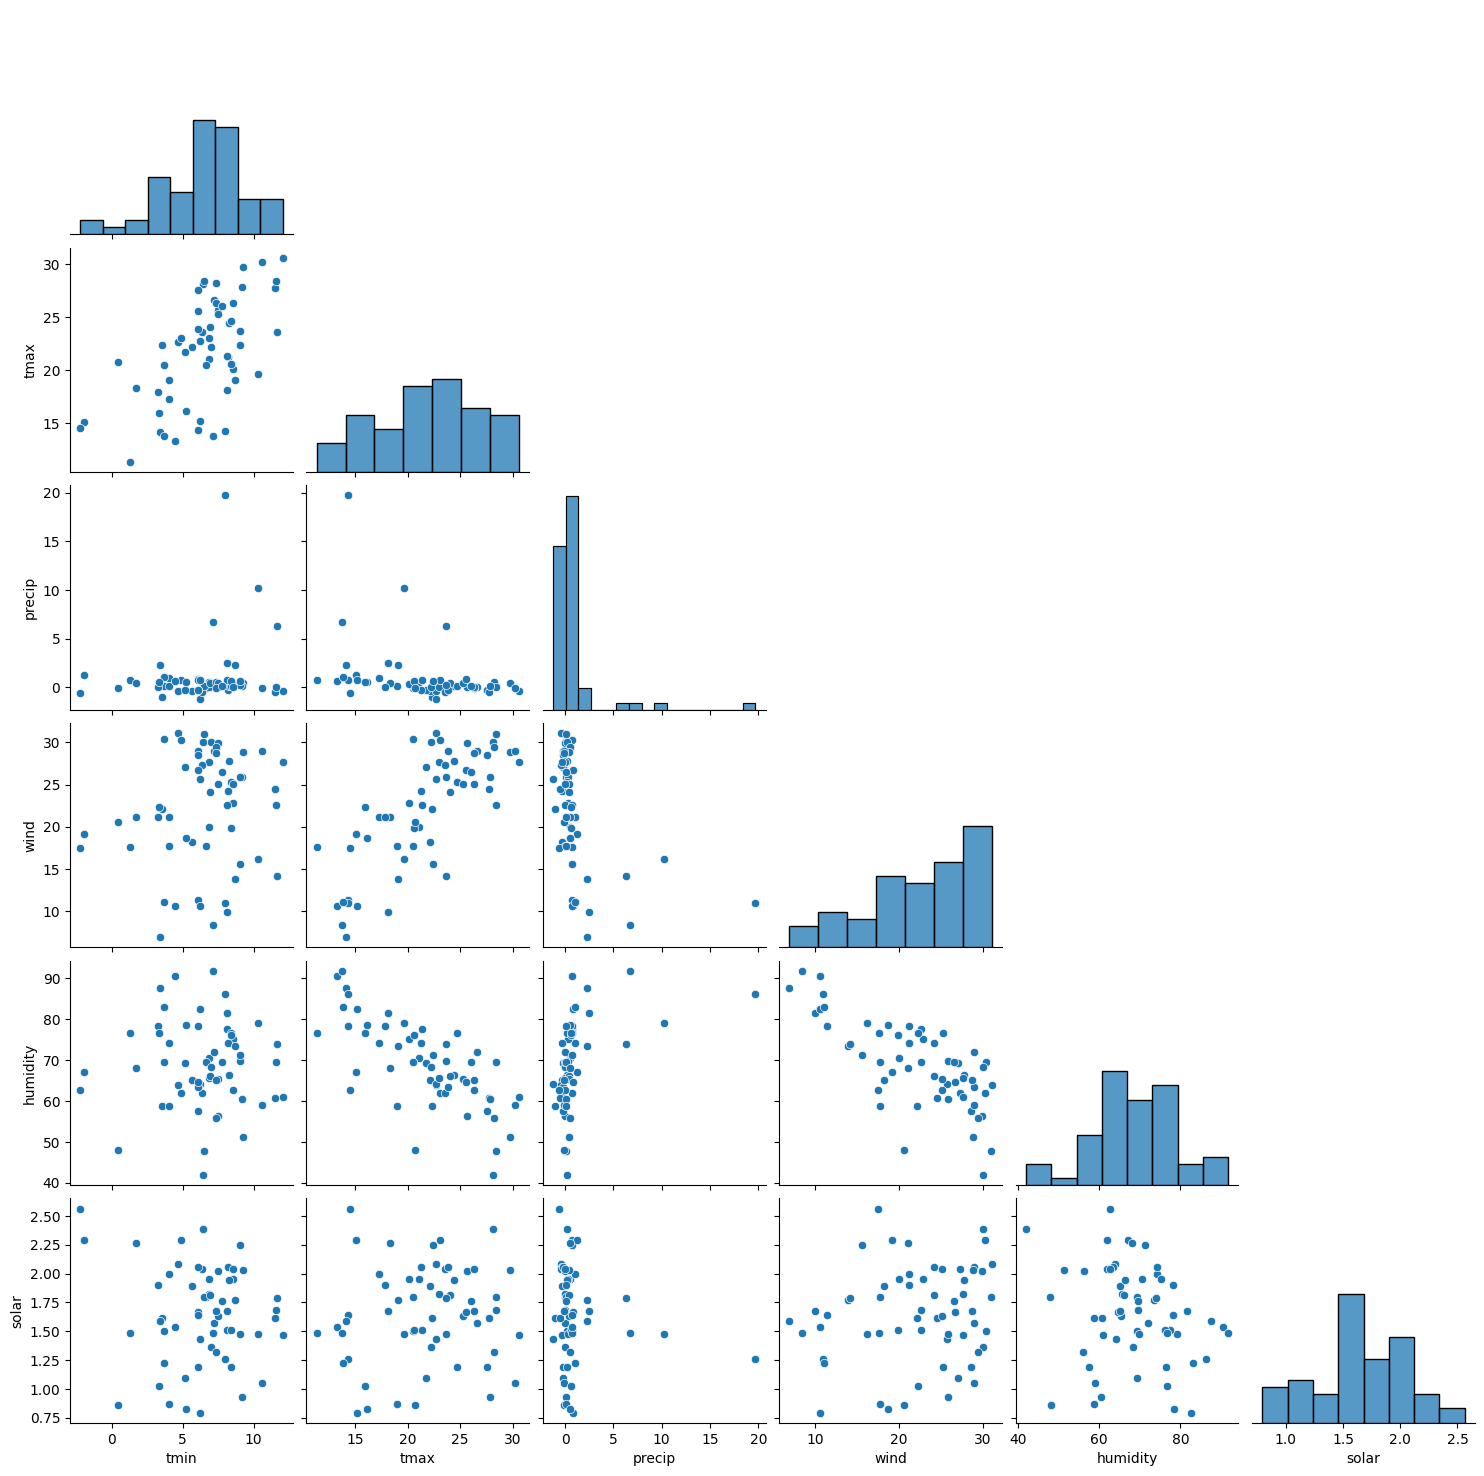

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

var_names = ["tmin", "tmax", "precip", "wind", "humidity", "solar"]

#X_mean = Omega.mean(axis=0)   # (60, 6)
X_mean = Omega[0]   # (60, 6)
df = pd.DataFrame(X_mean, columns=var_names)

sns.pairplot(df, corner=True, diag_kind="hist")
plt.show()

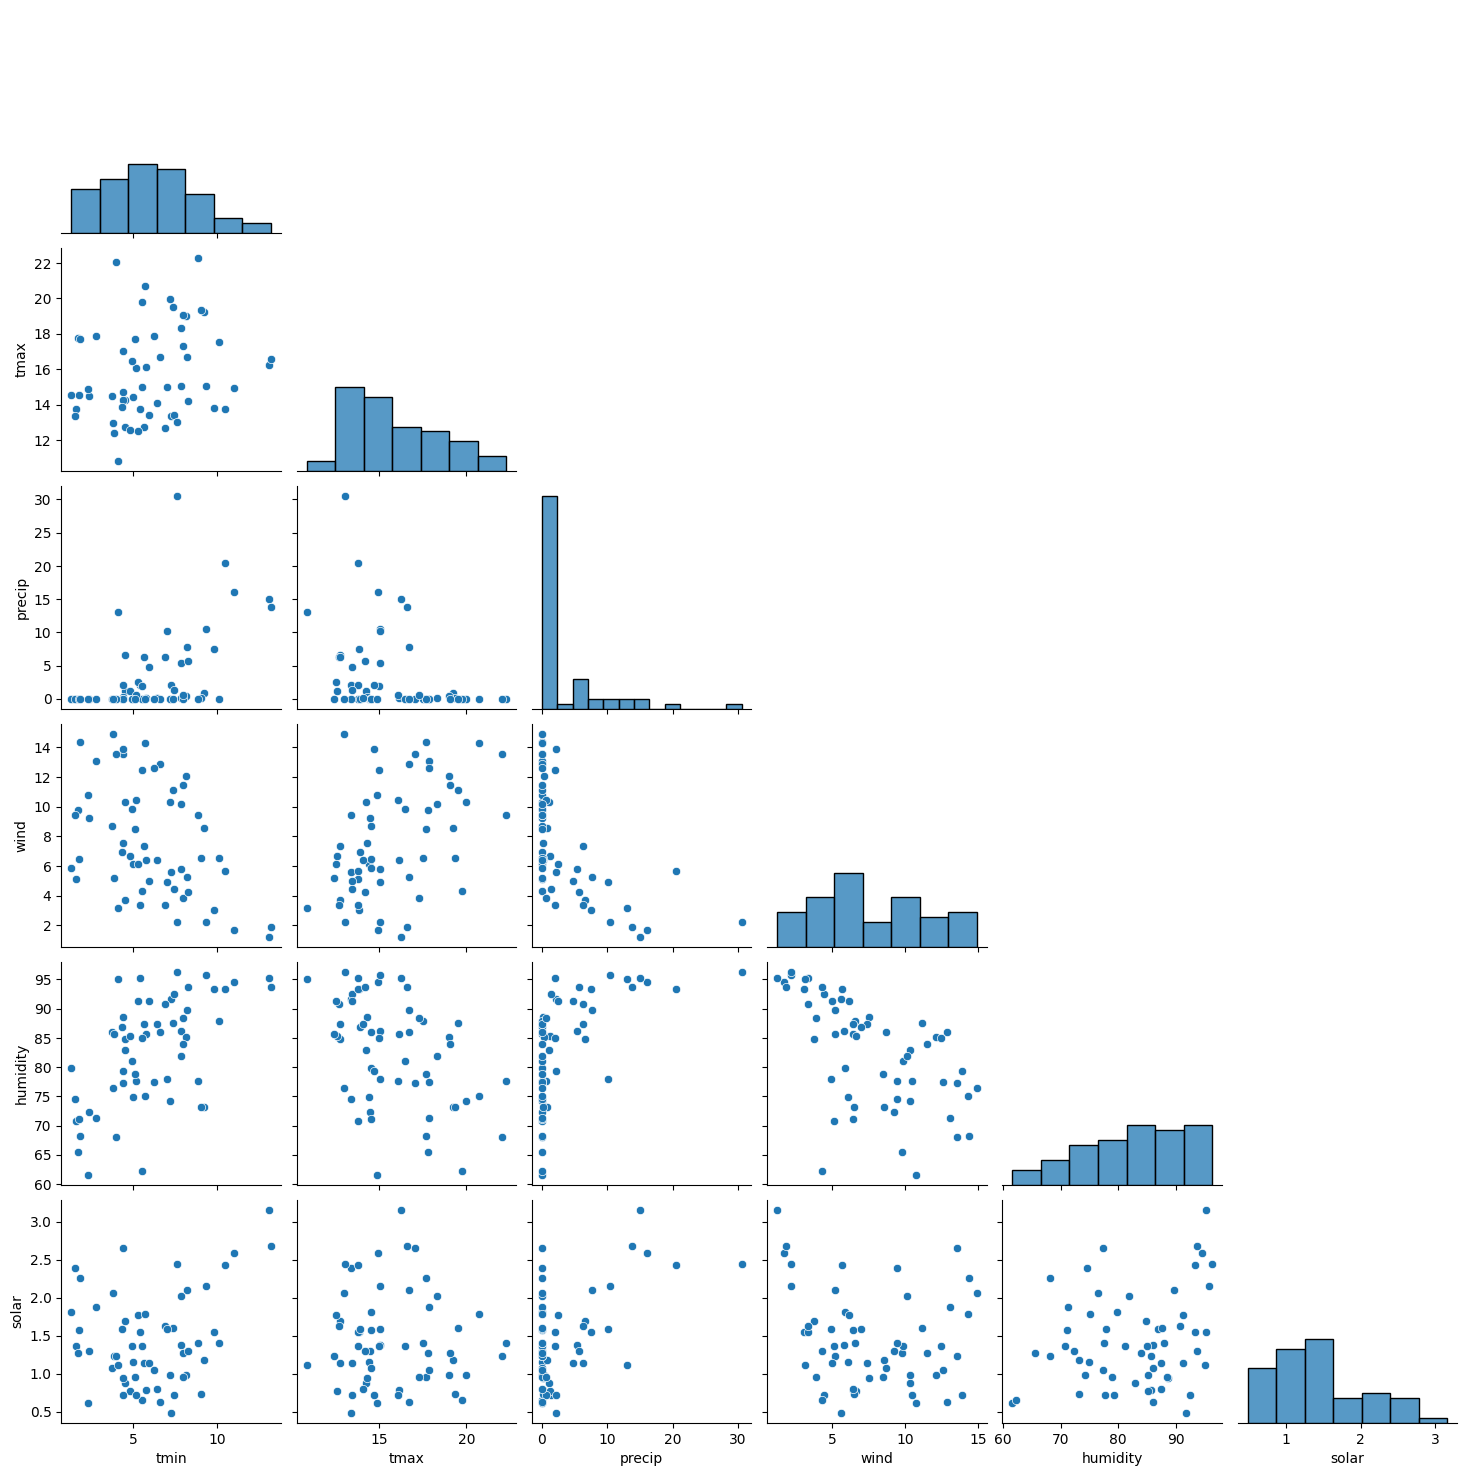

In [25]:
#X_mean = Omega.mean(axis=0)   # (60, 6)
X_mean = y   # (60, 6)
df = pd.DataFrame(X_mean, columns=var_names)

sns.pairplot(df, corner=True, diag_kind="hist")
plt.show()